## Longitudinal choice model
Description and examples: https://www.pymc.io/projects/examples/en/latest/generalized_linear_models/GLM-discrete-choice_models.html#the-basic-model

In [ ]:
# ------------------------------------------------------------------
# Load Libraries & Data
# ------------------------------------------------------------------
import os
os.environ['PYTENSOR_FLAGS'] = 'cxx=C:/msys64/ucrt64/bin/g++.exe,optimizer=fast_compile'
import importlib

import pymc as pm
import arviz as az

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import f_data_processing as dp
dp = importlib.reload(dp)

print(os.getcwd())

print(pm.__name__, pm)

c:\Users\stdt\ETH Zurich\PhD Veronika - 07_Master Thesis Natalie\10_hcm_code\natural_hazard_solidarity
pymc <module 'pymc' from 'c:\\Users\\stdt\\ETH Zurich\\PhD Veronika - 07_Master Thesis Natalie\\10_hcm_code\\.venv\\lib\\site-packages\\pymc\\__init__.py'>


In [ ]:
# prepare dummies without baseline in data for model
# load preprocessed data
df = pd.read_csv('../results/conjoint_df.csv', index_col=0)

# experimental variables and defining baseline values
attr_cols = ['costs', 'exemptions', 'benefits']
baselines = {'costs': 'All people pay the same amount', 'exemptions': 'No groups exempted from costs', 'benefits': 'Equal protection levels for all municipalities'}

#  reorder experimental columns making it Categorical starting with chosen baseline
for a in attr_cols:
    unique_levels = df[a].dropna().unique()
    cats = [baselines[a]] + [lvl for lvl in unique_levels if lvl != baselines[a]]
    df[a] = pd.Categorical(df[a], categories=cats)

# create dummies without baseline attribute level
df_num = pd.get_dummies(df[attr_cols], drop_first=True)

In [ ]:
# build task id
task_key = ['respondent_id', 'nh_event', 'task']
df['task_id'] = pd.factorize(df[task_key].apply(tuple, axis=1))[0]

# sort, so both, left and right option have same order
df = df.sort_values(['task_id', 'option']).copy()

# define right and left options
left_option  = 1
right_option = 2
left_mask  = df['option'] == left_option
right_mask = df['option'] == right_option

# check: per taks two rows with only one of them being chosen
counts = df.groupby('task_id').size()
assert (counts == 2).all(), 'Es gibt Tasks, die nicht genau 2 Alternativen haben.'
chosen_sum = df.groupby('task_id')['chosen'].sum()
assert (chosen_sum == 1).all(), 'Es gibt Tasks, bei denen chosen nicht genau einmal 1 ist.'

# X-matrices
X_left  = df_num.loc[left_mask].to_numpy()
X_right = df_num.loc[right_mask].to_numpy()

# observing, which option was chosen? was it left?
y_left = df.loc[left_mask, 'chosen'].to_numpy().astype(int)

# nh_event per task (0/1)
event = df.loc[left_mask, 'nh_event'].to_numpy().astype(int)

n_tasks = X_left.shape[0]

coords = {
    'level': df_num.columns.values,
    'task': np.arange(n_tasks)
}

In [ ]:
with pm.Model(coords = coords) as simple_model: 
    # data
    Xl = pm.Data('X_left', X_left, dims=('task', 'level'))
    Xr = pm.Data('X_right', X_right, dims=('task', 'level'))
    y = pm.Data('y_left', y_left, dims='task')
    e = pm.Data('event', event, dims='task') # NH event: 0/1 (before/after) per task
    
    # TODO change sigma and check what fits best, play with it, attribute levels: sigma 2
    # TODO: check beta values against veronikas 
    # sigma of latent constructs is expected to be smaller, so more than sigma 1
    # sigma 2 was tested but did not lead to any other results when not including the baseline directly in the dummies for the model
    beta = pm.Normal('beta', mu=0, sigma = 1, dims = 'level')   # pre event
    delta = pm.Normal('delta', mu=0, sigma = 1, dims = 'level') # shift after event
    beta_eff = beta + delta * e[:, None]     # (task, level)
    
    u_left = pm.Deterministic('u_left', pm.math.sum(Xl * beta_eff, axis = 1), dims='task')
    u_right = pm.Deterministic('u_right', pm.math.sum(Xr * beta_eff, axis = 1), dims='task')
    
    logit_p_left = pm.Deterministic('logit_p_left', u_left - u_right, dims='task')
    p_left = pm.Deterministic('p_left', pm.math.sigmoid(logit_p_left), dims='task') # not necessarily needed
    choice = pm.Bernoulli('choice', logit_p=logit_p_left, observed=y, dims='task')
    
    beta_post = pm.Deterministic('beta_post', beta + delta, dims='level')



In [12]:
# model test better approximation
with simple_model:
    # idata_mcmc_with_base = pm.sample(draws=500, tune=500, chains=4, cores = 4, target_accept=0.9, progressbar=True)
    idata_mcmc = pm.sample(draws=500, tune=500, chains=4, cores = 4, target_accept=0.9, progressbar=True)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, delta]


Output()

Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 242 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


In [ ]:
groups = ['costs', 'benefits', 'exemptions']
titles = {'costs':'Costs', 'benefits':'Benefits', 'exemptions':'Exemptions'}
color_map = {'costs':'tab:blue', 'benefits':'tab:orange', 'exemptions':'tab:green'}

baselines = {
    'costs':      'All people pay the same amount',
    'benefits':   'Equal protection levels for all municipalities',
    'exemptions': 'No groups exempted from costs',
}

summ_pre  = az.summary(idata_mcmc, var_names=['beta'],      hdi_prob=0.95).reset_index()
summ_post = az.summary(idata_mcmc, var_names=['beta_post'], hdi_prob=0.95).reset_index()

summ_pre  = dp.tidy(summ_pre,  'beta')
summ_post = dp.tidy(summ_post, 'beta_post')

baseline_rows_pre, baseline_rows_post = [], []
for g, name in baselines.items():
    baseline_rows_pre.append({
        'index': f'beta[{g}_{name}]',
        'mean': 0.0, 'sd': 0.0, 'hdi_2.5%': 0.0, 'hdi_97.5%': 0.0,
        'level_raw': f'{g}_{name}', 'group': g, 'label': name
    })
    baseline_rows_post.append({
        'index': f'beta_post[{g}_{name}]',
        'mean': 0.0, 'sd': 0.0, 'hdi_2.5%': 0.0, 'hdi_97.5%': 0.0,
        'level_raw': f'{g}_{name}', 'group': g, 'label': name
    })

summ_pre  = pd.concat([summ_pre,  pd.DataFrame(baseline_rows_pre)],  ignore_index=True)
summ_post = pd.concat([summ_post, pd.DataFrame(baseline_rows_post)], ignore_index=True)


summ = summ_pre.merge(
    summ_post[['level_raw','mean','hdi_2.5%','hdi_97.5%']],
    on='level_raw',
    suffixes=('_pre','_post')
)

summ

,index,mean_pre,sd,hdi_2.5%_pre,hdi_97.5%_pre,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,level_raw,group,label,mean_post,hdi_2.5%_post,hdi_97.5%_post
0,beta[costs_People pay proportionally to their ...,0.502,0.087,0.341,0.680,0.003,0.002,921.0,1334.0,1.01,costs_People pay proportionally to their income,costs,People pay proportionally to their income,0.399,0.255,0.525
1,beta[costs_People pay proportionally to their ...,0.020,0.090,-0.156,0.192,0.003,0.002,899.0,1340.0,1.00,costs_People pay proportionally to their CO2 e...,costs,People pay proportionally to their CO2 emissions,0.143,0.016,0.291
2,beta[costs_Companies pay proportionally to the...,0.587,0.099,0.406,0.793,0.004,0.002,792.0,1212.0,1.00,costs_Companies pay proportionally to their CO...,costs,Companies pay proportionally to their CO2 emis...,0.627,0.484,0.778
3,beta[costs_People & companies being protected ...,0.600,0.086,0.440,0.776,0.003,0.002,823.0,1403.0,1.00,costs_People & companies being protected by pr...,costs,People & companies being protected by protecti...,0.404,0.271,0.541
4,beta[exemptions_Low-income earners exempted fr...,0.625,0.080,0.468,0.778,0.003,0.002,842.0,1044.0,1.01,exemptions_Low-income earners exempted from costs,exemptions,Low-income earners exempted from costs,0.539,0.419,0.657
5,beta[exemptions_Low- and middle-income earners...,0.521,0.073,0.387,0.679,0.002,0.001,960.0,1311.0,1.01,exemptions_Low- and middle-income earners exem...,exemptions,Low- and middle-income earners exempted from c...,0.464,0.358,0.592
6,beta[benefits_Municipalities most affected by ...,0.245,0.087,0.082,0.410,0.003,0.002,1109.0,1469.0,1.01,benefits_Municipalities most affected by natur...,benefits,Municipalities most affected by natural hazard...,0.138,-0.004,0.263
7,beta[benefits_Municipalities in which people h...,-0.318,0.083,-0.462,-0.138,0.003,0.002,1039.0,1167.0,1.00,benefits_Municipalities in which people have l...,benefits,Municipalities in which people have lived in f...,-0.194,-0.316,-0.058
8,beta[benefits_Economically prosperous municipa...,-1.127,0.092,-1.310,-0.952,0.003,0.002,977.0,1364.0,1.01,benefits_Economically prosperous municipalities,benefits,Economically prosperous municipalities,-0.959,-1.096,-0.805
9,beta[benefits_Culturally valuable municipaliti...,-0.344,0.086,-0.507,-0.178,0.003,0.002,1119.0,1560.0,1.00,benefits_Culturally valuable municipalities e....,benefits,Culturally valuable municipalities e.g. with h...,-0.347,-0.474,-0.212


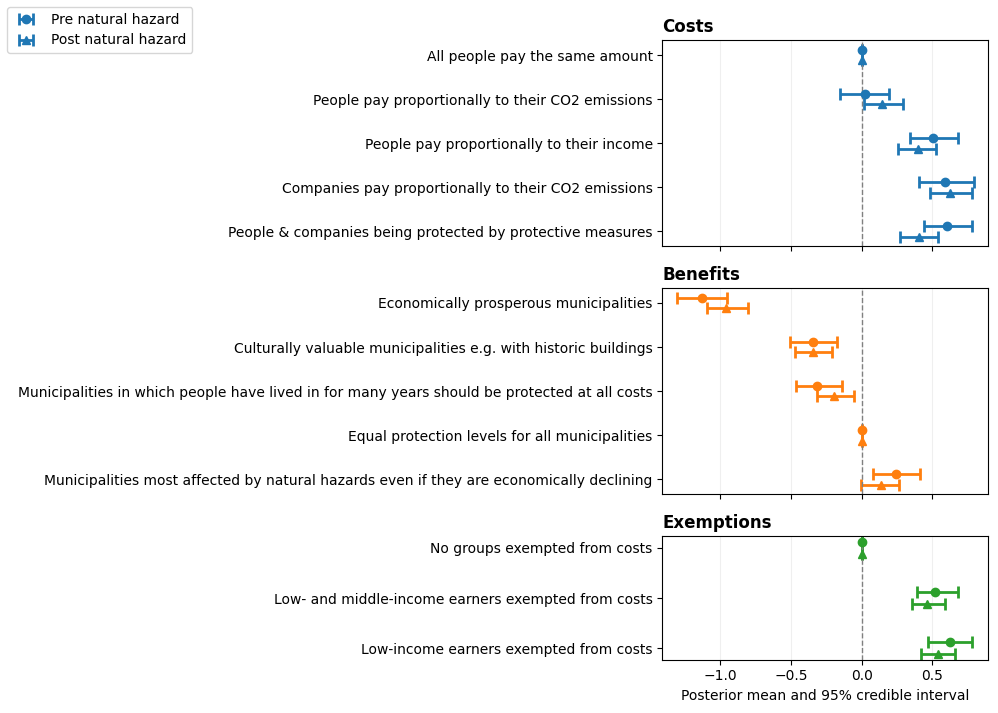

In [ ]:
# common coherent x limits for clear visualization
xmin = min(summ['hdi_2.5%_pre'].min(),  summ['hdi_2.5%_post'].min()) - 0.1
xmax = max(summ['hdi_97.5%_pre'].max(), summ['hdi_97.5%_post'].max()) + 0.1

# depending on number of attribute levels
heights = [max(1.4, 0.55 * len(summ[summ['group'] == g])) for g in groups]
offset = 0.12  # vertical separation between pre/post

fig, axes = plt.subplots(
    nrows=3, ncols=1, sharex=True,
    figsize=(10, sum(heights)),
    gridspec_kw={'height_ratios': heights}
)

for ax, g in zip(axes, groups):
    # sort by pre mean
    d = summ[summ['group'] == g].copy()
    d = d.sort_values('mean_pre')

    y0 = np.arange(len(d))[::-1].astype(float)
    y_pre  = y0 + offset
    y_post = y0 - offset
    c = color_map[g]

    # pre
    xerr_pre = np.vstack([d['mean_pre'] - d['hdi_2.5%_pre'], d['hdi_97.5%_pre'] - d['mean_pre']])
    ax.errorbar(d['mean_pre'], y_pre, xerr=xerr_pre, fmt='o', color=c, ecolor=c, elinewidth=2, capsize=4, capthick=2, label='Pre')

    # post
    xerr_post = np.vstack([d['mean_post'] - d['hdi_2.5%_post'], d['hdi_97.5%_post'] - d['mean_post']])
    ax.errorbar(d['mean_post'], y_post, xerr=xerr_post, fmt='^', color=c, ecolor=c, elinewidth=2, capsize=4, capthick=2, label='Post')

    ax.axvline(0, ls='--', lw=1, color='gray')
    ax.set_yticks(y0)
    ax.set_yticklabels(d['label'])
    ax.set_title(titles[g], loc='left', fontweight='bold')
    ax.grid(axis='x', alpha=0.2)
    ax.set_xlim(xmin, xmax)

# one legend for the whole figure
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles[:2], ['Pre natural hazard', 'Post natural hazard'], loc='upper left')
axes[-1].set_xlabel('Posterior mean and 95% credible interval')
plt.tight_layout()


In [ ]:
# model run
with simple_model:
    idata = pm.sample(
        draws = 1000, 
        tune = 500, 
        chains = 4,
        cores = 4, 
        random_seed = 42, 
        return_inferencedata = True, 
        target_accept = 0.9, 
        progressbar=True
    )